[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


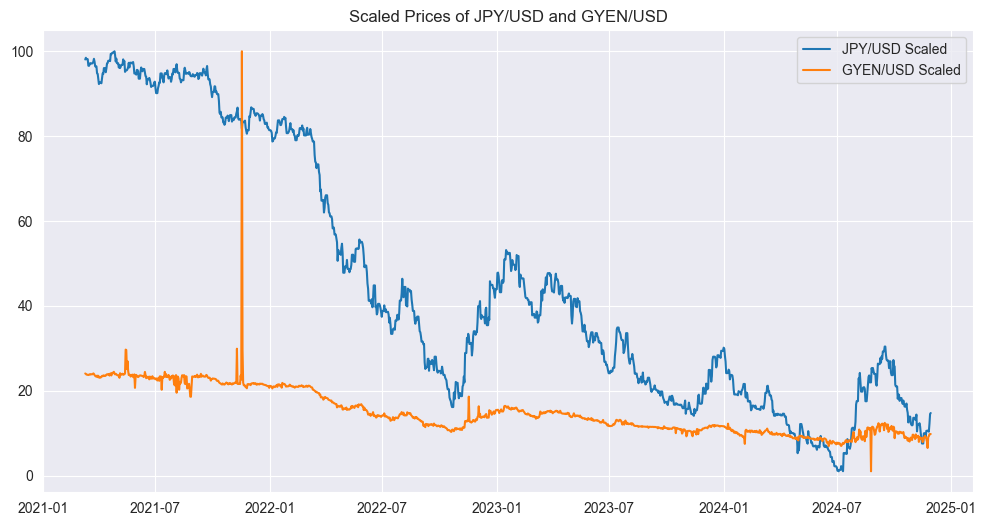

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1360
Model:                        SARIMAX   Log Likelihood               11928.330
Date:                Thu, 26 Dec 2024   AIC                         -23852.660
Time:                        15:04:00   BIC                         -23842.230
Sample:                    03-11-2021   HQIC                        -23848.755
                         - 11-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.908e-06   1.03e-06     -1.847      0.065   -3.93e-06    1.17e-07
sigma2       1.41e-09   5.72e-11     24.656      0.000     1.3e-09    1.52e-09
Ljung-Box (L1) (Q):                   0.69   Jarque-

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2158.0146 - val_loss: 1600.8130
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1473.2483 - val_loss: 1218.7284
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1189.9038 - val_loss: 1072.4130
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1047.0068 - val_loss: 953.3086
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 935.4194 - val_loss: 848.1361
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 828.1964 - val_loss: 754.0627
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 741.1636 - val_loss: 669.5978
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 656.6307 - val_loss: 593.3083
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 580.6935 - val_loss: 524.5286
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 517.4451 - val_loss: 462.4995
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 457.5126 - val_loss: 406.6420
Epoch 12/20
34/34 ━━━━━

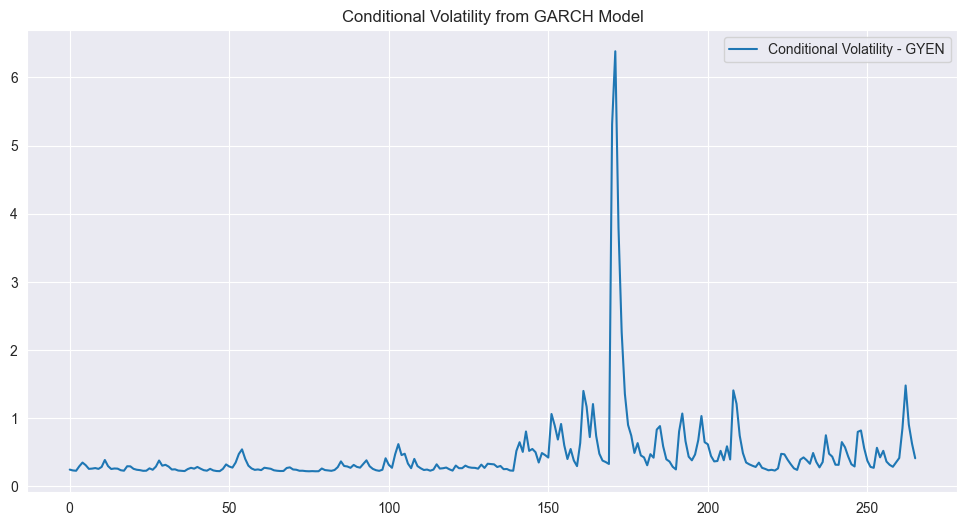

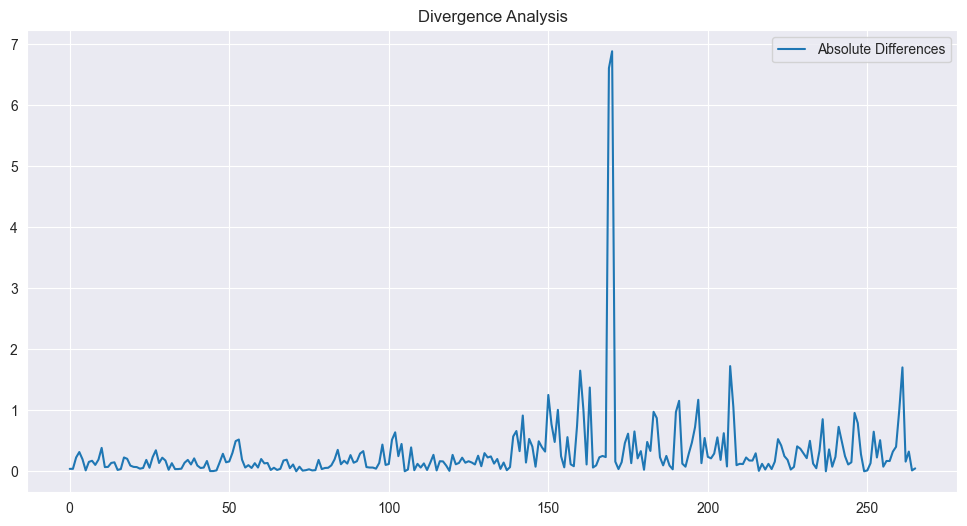

In [1]:
# Step 1: Data Collection and Preprocessing
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# 1.1. Downloading and Preparing Data
def download_and_prepare_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date, interval='1d')
    data.index = pd.to_datetime(data.index)
    data = data.asfreq('D')
    data.ffill(inplace=True)
    return data

jpy_usd = download_and_prepare_data('JPYUSD=X', '2021-03-10', '2024-11-30')
gyen_usd = download_and_prepare_data('GYEN-USD', '2021-03-10', '2024-11-30')

# Save data for reproducibility
jpy_usd.to_csv('JPY_USD_data.csv')
gyen_usd.to_csv('GYEN_USD_data.csv')

# 1.2. Data Normalization
scaler = MinMaxScaler(feature_range=(1, 100))
jpy_usd['Close_scaled'] = scaler.fit_transform(jpy_usd[['Close']])
gyen_usd['Close_scaled'] = scaler.fit_transform(gyen_usd[['Close']])

# 1.3. Stationarity Check
def check_stationarity(series):
    result = adfuller(series.dropna())
    return {'ADF Statistic': result[0], 'p-value': result[1]}

stationarity_jpy = check_stationarity(jpy_usd['Close'])
stationarity_gyen = check_stationarity(gyen_usd['Close'])

# Differencing to achieve stationarity
jpy_usd['Close_diff'] = jpy_usd['Close'].diff()
gyen_usd['Close_diff'] = gyen_usd['Close'].diff()

# Verify stationarity
stationarity_jpy_diff = check_stationarity(jpy_usd['Close_diff'])
stationarity_gyen_diff = check_stationarity(gyen_usd['Close_diff'])

# Plot scaled and differenced data
plt.figure(figsize=(12, 6))
plt.plot(jpy_usd.index, jpy_usd['Close_scaled'], label='JPY/USD Scaled')
plt.plot(gyen_usd.index, gyen_usd['Close_scaled'], label='GYEN/USD Scaled')
plt.title('Scaled Prices of JPY/USD and GYEN/USD')
plt.legend()
plt.show()

# Step 2: ARIMA Modeling
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# Auto ARIMA for optimal parameters
arima_jpy_model = auto_arima(jpy_usd['Close_diff'].dropna(), seasonal=False, stepwise=True)
arima_gyen_model = auto_arima(gyen_usd['Close_diff'].dropna(), seasonal=False, stepwise=True)

print(arima_jpy_model.summary())
print(arima_gyen_model.summary())

# Step 3: LSTM Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import numpy as np

# Prepare Data for LSTM
def prepare_lstm_data(series, time_steps):
    X, Y = [], []
    for i in range(len(series) - time_steps):
        X.append(series[i:i + time_steps])
        Y.append(series[i + time_steps])
    return np.array(X), np.array(Y)

time_steps = 30
scaled_gyen = scaler.fit_transform(gyen_usd['Close_diff'].dropna().values.reshape(-1, 1))
X_gyen, Y_gyen = prepare_lstm_data(scaled_gyen, time_steps)
X_train, X_test, Y_train, Y_test = train_test_split(X_gyen, Y_gyen, test_size=0.2, shuffle=False)

# LSTM Model Definition
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=32)

# Residuals for GARCH Modeling
residuals_gyen = Y_test.flatten() - model.predict(X_test).flatten()

# Step 4: GARCH Modeling
from arch import arch_model

# Fit GARCH Model
best_garch_model = arch_model(residuals_gyen, vol='Garch', p=1, q=1, dist='t')
garch_fit = best_garch_model.fit()

print(garch_fit.summary())

# Plot Conditional Volatility
plt.figure(figsize=(12, 6))
plt.plot(garch_fit.conditional_volatility, label='Conditional Volatility - GYEN')
plt.title('Conditional Volatility from GARCH Model')
plt.legend()
plt.show()

# Step 5: Divergence Analysis
# Calculate absolute differences in residuals
absolute_differences = np.abs(residuals_gyen - residuals_gyen.mean())
plt.figure(figsize=(12, 6))
plt.plot(absolute_differences, label='Absolute Differences')
plt.title('Divergence Analysis')
plt.legend()
plt.show()
